# barotropic streamfunction

Chris Bull (28/6/24) 

This draft notebook plots the barotropic streamfunction for each model as the time mean of the last available year for Ocean0, Ocean1 and Ocean2 COM runs.

Heavily hacked from OverturningStreamfunction.ipynb (thanks Adele!)

See https://github.com/misomip/isomip-plus/issues/6#issuecomment-2167202395

In [5]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors
from matplotlib import pyplot as plt, animation
%matplotlib inline

# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display
# this is to make sure there is no size limit
import matplotlib

matplotlib.rcParams['animation.embed_limit'] = 2**128
import matplotlib.gridspec as gridspec


In [2]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)

def get_labels(expt):
    '''
    Get labels of experiments
    Make some modifications to names
    '''
    labels = []
    for fileIndex in range(len(expt)):
        fileName = expt[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        if "COM" in fileName:
            #make edits to COM names
            if "MOM6" in fileName:
                if "SIGMA_ZSTAR" not in fileName:
                    modelName = modelName + '-LAYER'
            elif "ROMS" in fileName:
                modelName = "ROMS"
        elif "TYP" in fileName:
            # make edits to COM names
            if "MOM6" in fileName:
                modelName = modelName + '-LAYER'
            elif "CNRS" in fileName:
                if "TYPa" in fileName:
                    modelName = modelName + '-TYPa'
                elif "TYPb" in fileName:
                    modelName = modelName + '-TYPb'
            elif "tides" in fileName:
                modelName = "ROMS-tides"
            elif "ROMS" in fileName:
                modelName = "ROMS"
        labels.append(modelName.strip('V3').replace(" ", "-"))
    return labels


In [13]:
linewidths = np.ones(21)*0.4
linewidths[10]=1.0
linestyles = ['--','--','--','--','--','--','--','--','--','--',
              'dotted',
              '-','-','-','-','-','-','-','-','-','-',]

In [23]:
def pbsf_full_video(expt,suptitle,savename,customlim=1, xlimmin = 440, figsize = (20,4.5)):
    labels = get_labels(expt)
    length = len(expt)
    alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
    nrows = int(np.ceil(length/3))
    fig = plt.figure(figsize=figsize,facecolor='w',dpi = 150)
    time = 0
    axes = []
    for i in np.arange(length):
        ax = plt.subplot(3,nrows,i+1)
        axes = np.append(axes,ax)
        data = xr.open_dataset(basedrive+expt[i], decode_times=False)
        #print(data.nTime)
        mr = data.barotropicStreamfunction.isel(nTime = time)
        # last year of time
        #mr['nz'] = mr.nz*5+2.5 # add depth (2.5,7.5 etc)
        mr['ny'] = mr.ny*2
        mr['nx'] = mr.nx*2+321
        # mr<1e36 is to get rid of NaNs.
        c = (mr.where(mr <1e36).where(mr !=0)/1e6).plot.contourf(cmap = cm.cm.curl, levels = np.linspace(-customlim,customlim,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
        ls = (mr.where(mr <1e36).where(mr !=0)/1e6).plot.contour( levels = np.linspace(-customlim,customlim,21), colors = 'k', linestyles = linestyles, linewidths = 0.7)
        mr2 = (mr.where(mr<1e36).where(mr !=0)*0+1).fillna(0).sel(nx = slice(0,640)).plot.contour(levels = [0.5], colors = 'k',alpha = 0.5)
        xlim = [xlimmin, 800.]
        plt.xlim(xlim)
        plt.ylim(0,80)
        c.axes.set_aspect('equal')
#        plt.title('('+alphabet[i]+') '+labels[i], fontsize = 16)
        plt.text(0.01,1.01,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='bottom')
        plt.text(0.01,1.01,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='bottom')
        plt.yticks([0,40,80])
        if (i<nrows*2):
            ax.set_xticklabels([])
        if (i==0) or (i==nrows) or (i==nrows*2):
            plt.ylabel('y (km)', fontsize = 16)
        else:
            ax.set_yticklabels([])
            plt.ylabel('')
        if i>=nrows*2:
            plt.xlabel('x (km)', fontsize = 16)
        else:
            plt.xlabel('')
        plt.tick_params(labelsize=16)
        plt.vlines(640,0,80,color = 'steelblue', linestyle = '--',linewidth =0.7)


    cax = plt.axes([0.93,0.1,0.01,0.8])
    cbar = plt.colorbar(c, cax = cax)
    cbar.ax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 16)
    cbar.add_lines(ls)
    cbar.ax.set_yticks(np.arange(-customlim,customlim+0.0001,customlim/5))
    plt.tick_params(labelsize=16)
    fig.subplots_adjust(wspace = 0.05, hspace = 0.05)

    fig.suptitle(suptitle+', time = '+'{0:.2f}'.format((time+0.5)/12)+'yr', y = 0.97, x= 0.3, ha = 'left', fontsize = 20);

    def animate(frame):
        for i in np.arange(length):
            axes[i].clear()
            ax = axes[i]
    
            data = xr.open_dataset(basedrive+expt[i], decode_times=False)
            #print(data.nTime)
            mr = data.barotropicStreamfunction.isel(nTime = frame)
            # last year of time
            #mr['nz'] = mr.nz*5+2.5 # add depth (2.5,7.5 etc)
            mr['ny'] = mr.ny*2
            mr['nx'] = mr.nx*2+321
            # mr<1e36 is to get rid of NaNs.
            c = (mr.where(mr <1e36)/1e6).plot.contourf(ax = ax,cmap = cm.cm.curl, levels = np.linspace(-customlim,customlim,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
            ls = (mr.where(mr <1e36)/1e6).plot.contour(ax = ax, levels = np.linspace(-customlim,customlim,21), colors = 'k', linestyles = linestyles, linewidths = 0.7)
            mr2 = (mr.where(mr<1e36).where(mr !=0)*0+1).fillna(0).sel(nx = slice(0,640)).plot.contour(levels = [0.5], colors = 'k',alpha = 0.5)
            xlim = [xlimmin, 800.]
            ax.set_xlim(xlim)
            ax.set_ylim(0,80)
            c.axes.set_aspect('equal')
    #        plt.title('('+alphabet[i]+') '+labels[i], fontsize = 16)
            ax.text(0.01,1.01,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='bottom')
            ax.text(0.01,1.01,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='bottom')
            ax.set_yticks([0,40,80])
            if (i<nrows*2):
                ax.set_xticklabels([])
            if (i==0) or (i==nrows) or (i==nrows*2):
                ax.set_ylabel('y (km)', fontsize = 16)
            else:
                ax.set_yticklabels([])
                ax.set_ylabel('')
            if i>=nrows*2:
                ax.set_xlabel('x (km)', fontsize = 16)
            else:
                ax.set_xlabel('')
            #plt.tick_params(labelsize=16)
            ax.vlines(640,0,80,color = 'b', linestyle = '-',linewidth =1)
        fig.suptitle(suptitle+', time = '+'{0:.2f}'.format((frame+0.5)/12)+'yr', y = 0.97, x= 0.3, ha = 'left', fontsize = 20);
        cbar.ax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 16)

    # Finally, we use the animation module to create the animation.
    ani = animation.FuncAnimation(
        fig,             # figure
        animate,         # name of the function above
        frames=240,       # Could also be iterable or list
        interval=50     # ms between frames
    )
    #save!
    ani.save('/g/data/x77/cy8964/isomip-plus/videos/'+savename+'BSF.mp4',dpi = 300)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 6000x1350 -pix_fmt rgba -framerate 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /g/data/x77/cy8964/isomip-plus/videos/Ocean1COMBSF.mp4


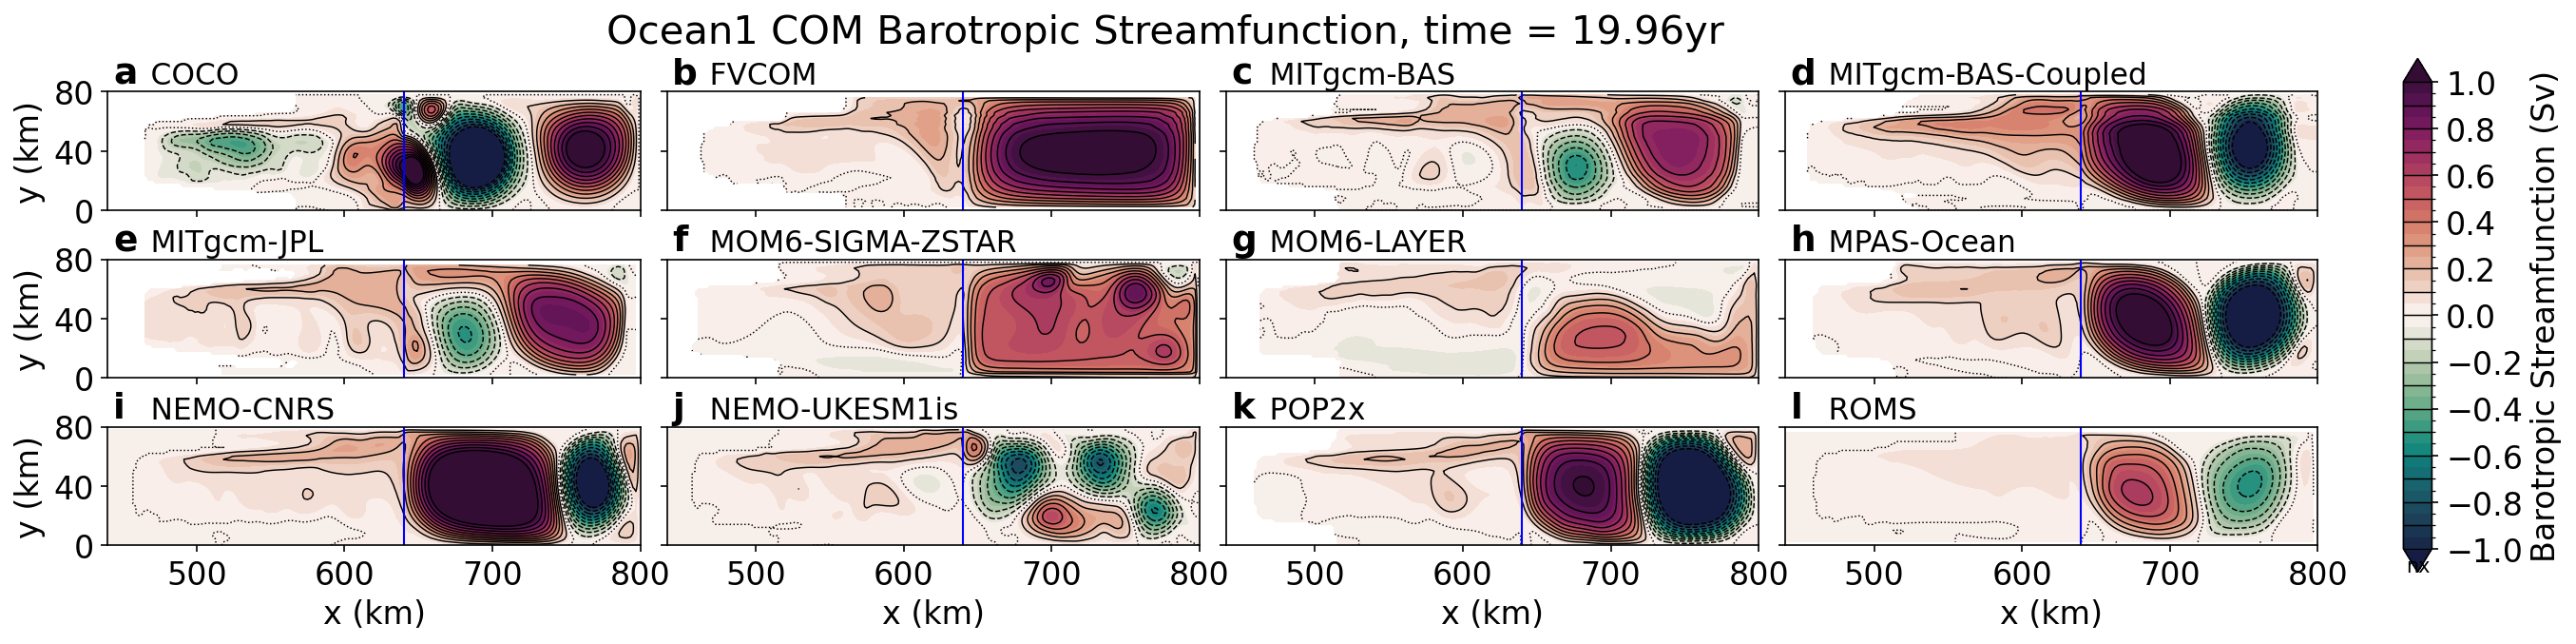

In [24]:
expt = Ocean1_COM
pbsf_full_video(expt,'Ocean1 COM Barotropic Streamfunction','Ocean1COM',1)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 6000x1350 -pix_fmt rgba -framerate 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /g/data/x77/cy8964/isomip-plus/videos/Ocean2COMBSF.mp4


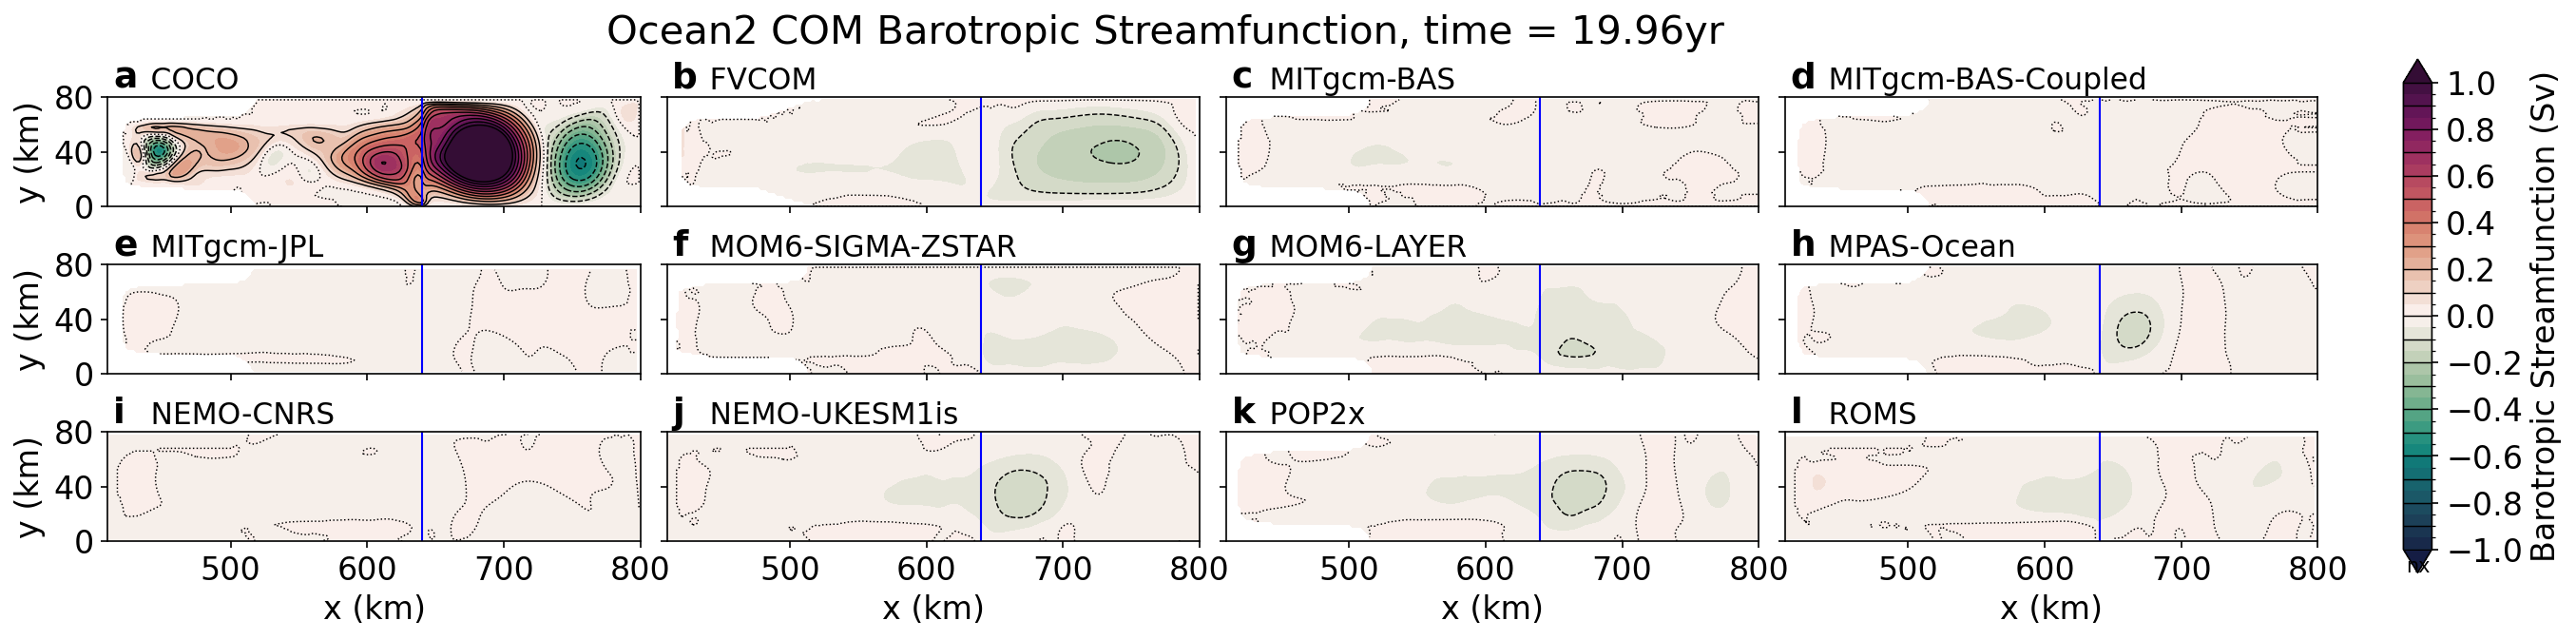

In [25]:
expt = Ocean2_COM
pbsf_full_video(expt,'Ocean2 COM Barotropic Streamfunction','Ocean2COM',1,xlimmin = 410)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 4500x1350 -pix_fmt rgba -framerate 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /g/data/x77/cy8964/isomip-plus/videos/Ocean1TYPBSF.mp4


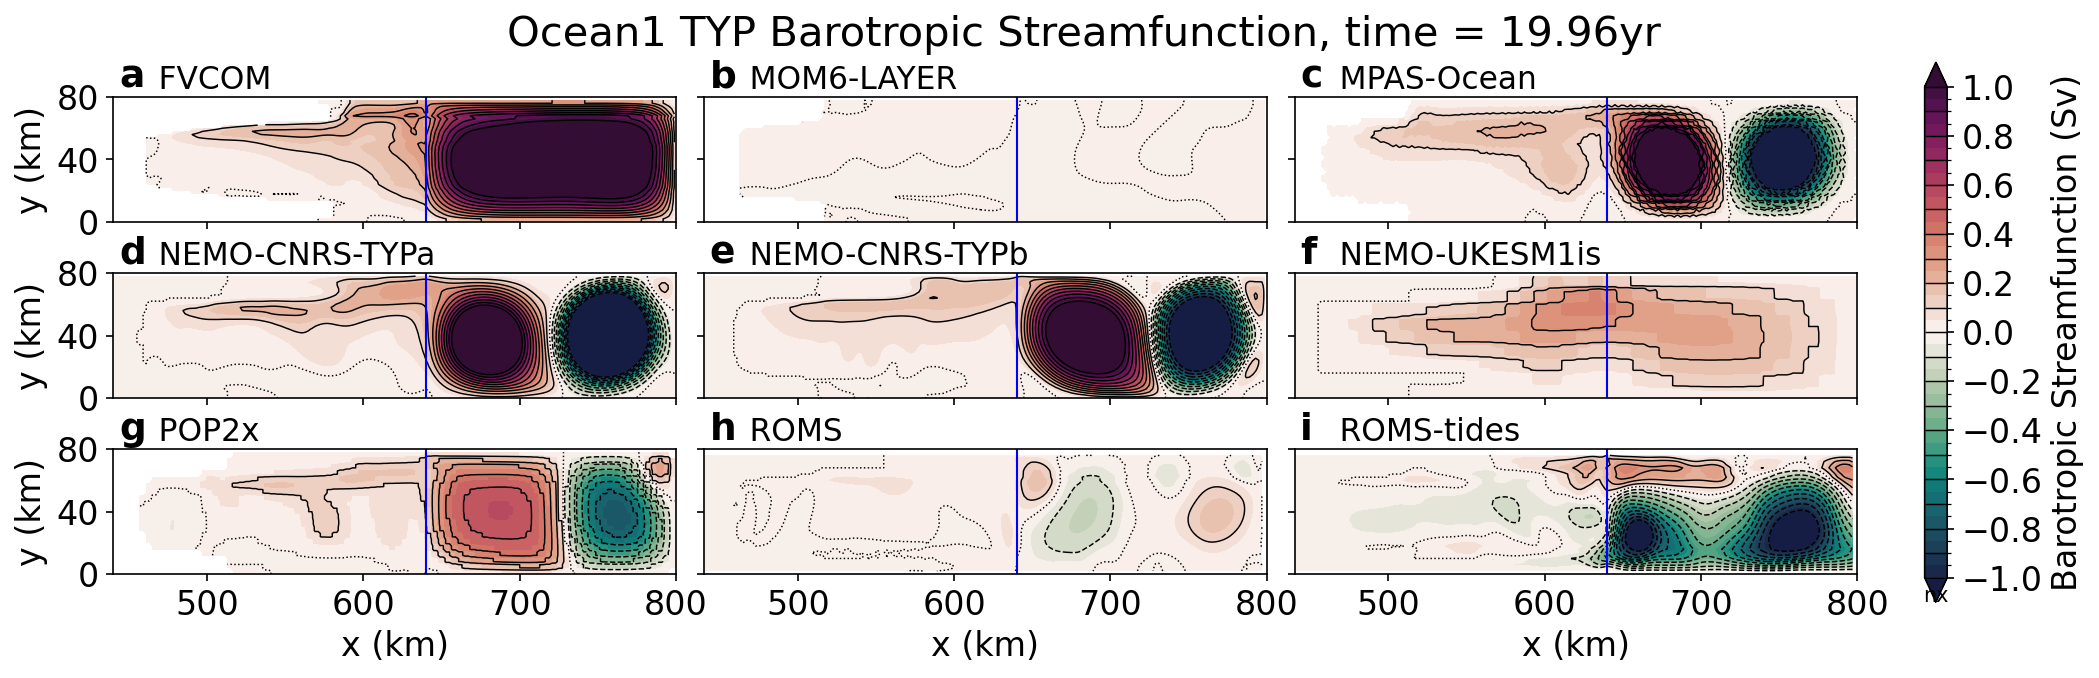

In [26]:
expt = Ocean1_TYP
pbsf_full_video(expt,'Ocean1 TYP Barotropic Streamfunction','Ocean1TYP',1, figsize = (15,4.5))

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 4500x1350 -pix_fmt rgba -framerate 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /g/data/x77/cy8964/isomip-plus/videos/Ocean2TYPBSF.mp4


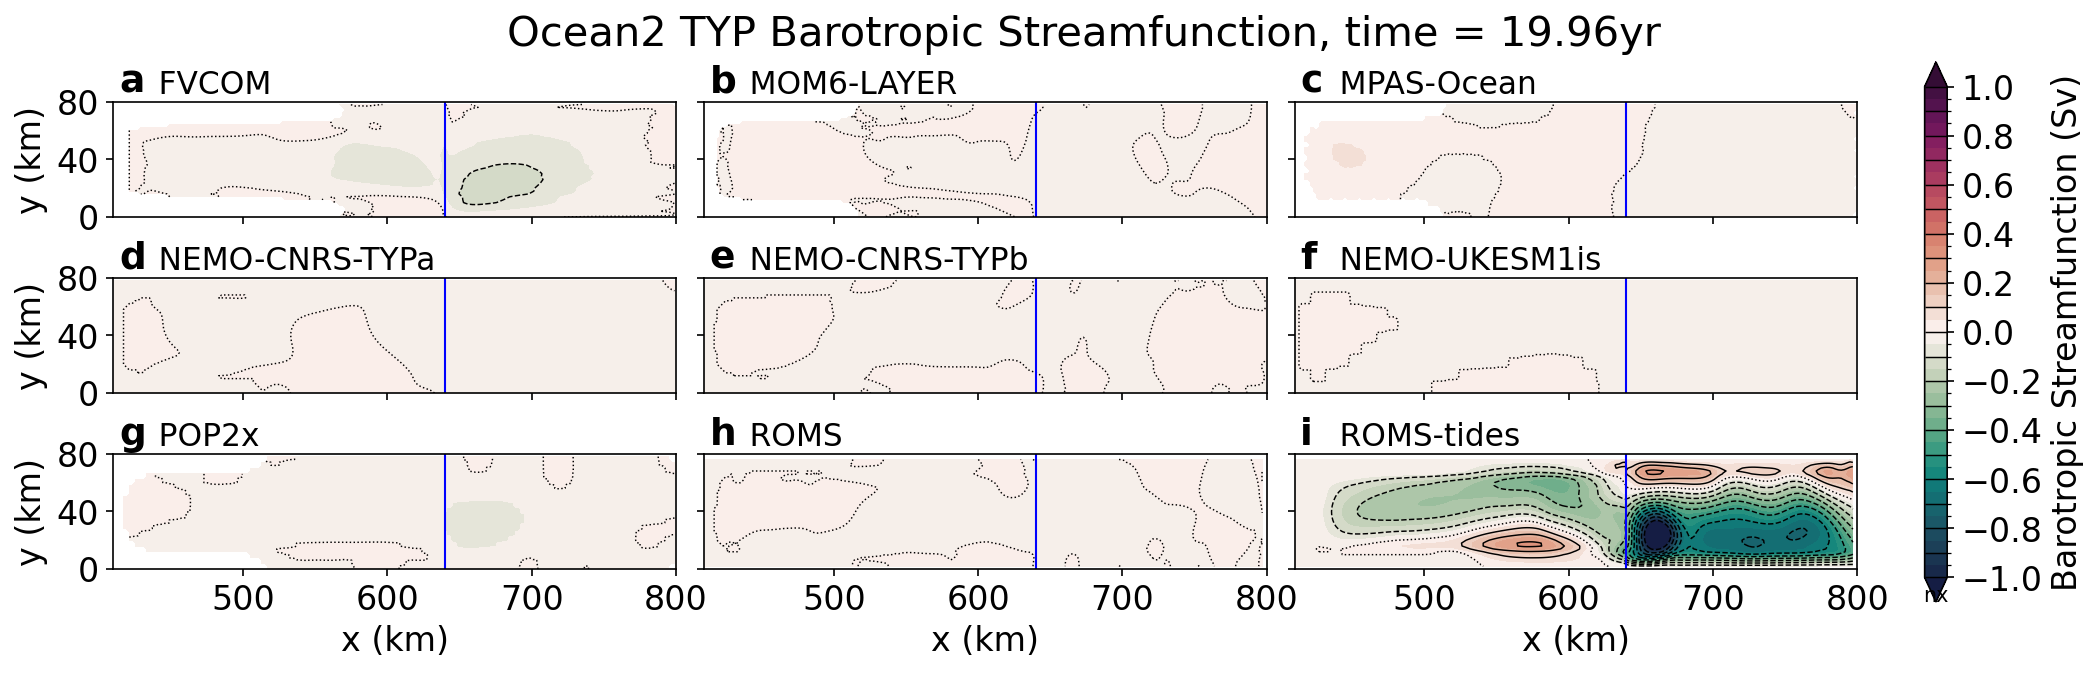

In [27]:
expt = Ocean2_TYP
pbsf_full_video(expt,'Ocean2 TYP Barotropic Streamfunction','Ocean2TYP',1,xlimmin = 410,figsize = (15,4.5))